In [1]:
import os
import numpy as np
import pandas as pd
import nltk
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from string import punctuation
import matplotlib.pyplot as plt 

# nltk.download("punkt")
# nltk.download("stopwords")
# nltk.download("wordnet")

# This is our own tokenizer
from nltk.tokenize import RegexpTokenizer

from docx import Document

# set wd
wd = '/Users/Felicia/Documents/ComputationalLaw/'

# import txt file
with open('merged_total_cleaned.txt','r') as f_open:
    data = f_open.read()

# print(data)


In [2]:
# separate data into paragraphs, so each paragraph is 1 case

data2 = re.split('\n----------\n',data) # This sets "\n----------\n" as paragraph delimiter.
len(data2)

2120

In [3]:
# create empty dfs to fill
columns = ['case_number', 'case_name', 'date', 'state', 'county', 
           'amount', 'pertinent_info', 'plaintiff', 'defendant','numOfPlaintiff', 'numOfDefendant',
           'DefendantPersonOrCorp', 'injury_list', 'event_narrative', 
           'mediator', 'judge', 'experts','attorneys','gender','age']

finaldf = pd.DataFrame(index=range(0,len(data2)), columns=columns)

columns2 = ['case_number', 'case_name', 'abdominal', 'ankle', 'arm', 'back', 'brain', 'burn', 'bowel', 'chest', 
            'circulatory', 'ear', 'elbow', 'eye', 'face', 'foot', 'leg', 'hand', 'heart', 
            'hip', 'kidney', 'knee', 'liver', 'mouth', 'muscle', 'neck', 'nose', 'pelvic', 'reproductive', 'respiratory',
            'shoulder', 'spinal', 'thigh', 'urinary','whole_body', 'wrist', 'pancreas','cancer', 
            'psychological', 'death']

injury_df = pd.DataFrame(index=range(0,len(data2)), columns=columns2)

state_set= set(['AL','AK','AZ','AR','CA','CO','CT','DE','FL','GA','HI','ID','IL','IN','IA',
             'KS','KY','LA','ME','MD','MA','MI','MN','MS','MO','MT','NE','NV','NH','NJ',
             'NM','NY','NC','ND','OH','OK','OR','PA','RI','SC','SD','TN','TX','UT','VT',
             'VA','WA','WV','WI','WY'])
# use case_name to merge dfs because sometimes case number isn't published

In [4]:
# fill in finaldf (excludes injuries)

# !!!! date is inconsistent

for x in range(0, len(data2)):
    a = data2[x]
    words = a.split()
    
    if words[0] !='AMOUNT:': #if the first word isn't AMOUNT, it's not a case but page number etc.
        finaldf.loc[x] = np.nan #fill entire row with NA
        
    else: #if it's a case
        lines = a.splitlines() #split the paragraph into lines

        for i in range(0, len(lines)): 
            line = lines[i]
            
            w = str.lower(lines[i]).split() #convert text to lowercase and split into words   
            
            if w[0] == 'amount:':
                amount=  w[1].replace('$', '').replace(',','').rstrip(punctuation)
    
                # Deal with misrecognition of ',' as '.'
                if '.' in amount:
                    try:
                        # Delete '.' only when '.' is NOT a decimal, i.e. '.' is NOT 3rd or 2nd to last
                        if amount[-3] != '.' and amount[-2] != '.':
                            amount=  amount.replace('.','')     
                    except IndexError:
                            amount= np.nan
                    
                # Identify cases where the amount is invalid (i.e. cannot be converted to float).
                try:
                    finaldf.loc[x, 'amount']= int(float(amount))
                except ValueError:
                    finaldf.loc[x, 'amount']= np.nan

                # State
                s= line[line.find('(')+1 : line.find(')')] # string in the first parentheses
                state= s.split()[-1].replace('.','')
                if state not in state_set:
#                     print('***Wrong state***')
#                     print(line)
#                     print(s)
#                     print(state)
                    state= np.nan
                finaldf.loc[x,'state'] = state
        
                # County
                if 'Co.' in s:
                    county= s[0:s.find('Co.')].rstrip(punctuation+' ')
                else:
#                     print('***No county***')
#                     print(line)
#                     print(s)
                    county= np.nan
                finaldf.loc[x,'county'] = county
        
            if w[0] == 'case' and w[1] == 'number:':
                finaldf.loc[x, 'case_number'] = ' '.join(w[2:len(w)])             
            if w[0] == 'case:':
                finaldf.loc[x, 'case_name'] = ' '.join(w[1:len(w)])
                
                #date
                date = line[line.rfind('(')+1:line.rfind(')')]
                finaldf.loc[x, 'date'] = date
                
                #plaintiffs and defendants: find when it says "v."
                y = [ww for ww in w if ww == 'v.'] #find v
                d = [str(s) for ww in w for s in ww.split() if s.isdigit()] #find year
                               
                if len(y) > 0: #we found v.
                    finaldf.loc[x, 'plaintiff'] = ' '.join(w[1:w.index('v.')])
                    finaldf.loc[x, 'numOfPlaintiff'] = len([i for i in w[1:w.index('v.')] if i == "and" or i ==  "&"]+[i for i in ' '.join(w[1:w.index('v.')]) if i == ","])+1
                else:
                    finaldf.loc[x, 'plaintiff'] = np.nan
                    finaldf.loc[x, 'numOfPlaintiff'] = np.nan
                if len(d) > 0 and len(y) > 0: #we found year
                    d = d[0].replace("'","")
                    finaldf.loc[x, 'defendant'] = ' '.join(w[w.index('v.')+1:w.index(d)])
                    finaldf.loc[x, 'numOfDefendant'] = len([i for i in w[w.index('v.'):w.index(d)] if i == "and" or i ==  "&"])+1
                    
                    z = str.lower(lines[i]).replace(",","").split()
                    zz = [i for i in z if i == "facility" or i== "hospital" or i== "group" or i== "department" or i== "realty"
                     or i== "usa" or i== "inc." or i== "clinic" or i== "corporation" or i== "co." or i== "corp." or i== "restaurant"
                     or i== "assoc." or i== "u.s.a." or i== "hosp." or i== "park" or i== "center" or i== "state" 
                          or i== "america" or i== "l.l.c." or i== "companies" or i== "university" or i== "district" 
                          or i== "regional" or i== "associates" or i== "construction" or i== "dental" or i== "county" or i== "society"]
                    
                    if len(zz) > 0:
                        finaldf.loc[x, 'DefendantPersonOrCorp'] = "corporation"
                    else:
                        finaldf.loc[x, 'DefendantPersonOrCorp'] = "person"
                        
                else:
                    finaldf.loc[x, 'defendant'] = np.nan   
                    finaldf.loc[x, 'numOfDefendant'] = np.nan
                
            if w[0] == 'mediator:':
                finaldf.loc[x, 'mediator'] = ' '.join(w[1:len(w)])                
            if w[0] == 'judge:':
                finaldf.loc[x, 'judge'] = ' '.join(w[1:len(w)])
            if w[0] == 'attorneys:':
                finaldf.loc[x, 'attorneys'] = ' '.join(w[1:len(w)])
            if w[0] == 'experts:':
                finaldf.loc[x, 'experts'] = ' '.join(w[1:len(w)])    
                
            if (w[0] == 'injured' and w[1] == 'party:') or (w[0] == 'injury' and w[1] == 'party:') or (w[0] == 'decedent:'):
                w = [ww.replace("-"," ") for ww in w] #turns 16-yo to "16 yo"
                finaldf.loc[x, 'age'] = [s for ww in w for s in ww.split() if s.isdigit()]
                g1 = ['male' for ww in w if ww=="male" or ww=="man" or ww=="boy"]
                g2 = ['female' for ww in w if ww=="female" or ww=="woman" or ww=="girl"]
                if len(g1) > len(g2):
                    finaldf.loc[x, 'gender'] = "male"
                elif len(g2) > len(g1):
                    finaldf.loc[x, 'gender'] = "female"
                else:
                    finaldf.loc[x, 'gender'] = "multiple"   
                    
            if (w[0] == 'injured' and w[1] == 'parties:') or (w[0] == 'injury' and w[1] == 'parties:'):
                finaldf.loc[x, 'gender'] = "multiple"
                
            if w[0] == 'event:':
                finaldf.loc[x, 'event_narrative'] = ' '.join(w[1:len(w)])
            if (w[0] == 'specific' and w[1] == 'injury:') or (w[0] == 'specific' and w[1] == 'injuries:'):
                finaldf.loc[x, 'injury_list'] = ' '.join(w[2:len(w)])
            if w[0] == 'pertinent' and w[1] == 'information:':     
                finaldf.loc[x, 'pertinent_info'] = ' '.join(w[2:len(w)])
   

In [5]:
# remove duplicates of multiple casefiles (identify using case_number)   
# based on 2 columns to prevent dropped all of the "not published cases"
finaldf = finaldf.drop_duplicates(subset=['case_number','case_name'])
finaldf

,case_number,case_name,date,state,county,amount,pertinent_info,plaintiff,defendant,numOfPlaintiff,numOfDefendant,DefendantPersonOrCorp,injury_list,event_narrative,mediator,judge,experts,attorneys,gender,age
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,cv-2007-000134,"jeremy freeman v. southern medical group, 2014...",October 2014,AL,Walker,1150000,NaN,jeremy freeman,"southern medical group,",1,1,corporation,cardiac arrest; punctured abdominal wall; death,the plaintiff alleged that the defendant plast...,NaN,jerry k. selman',"wayne ross, forensic pathology, lancaster, pa,...","dennis e. goldasich, jr., joshua m. vick and j...",female,[65]
2,not published,"plaintiff v. defendant doctor, 2016 medical li...",January 2016,CA,Los Angeles,1000000,NaN,plaintiff,"defendant doctor,",1,1,person,injury to common bile duct and hepatic artery,the plaintiff alleged that the defendant injur...,NaN,not published,"catherine m. graves, m.b.a., economist, fuller...","jeffrey a. milman of hodes milman, irvine, ca,...",female,[]
3,3:09-cv-00026,"jackson v. usa, 2012 medical litig. alert lexi...",July 2012,FL,NaN,750000,the case was settled prior to trial. the plain...,jackson,"usa,",1,1,corporation,peritonitis; sepsis; stroke; permanent cogniti...,the plaintiff went the emergency room of the d...,NaN,"timothy j. corrigan,",not published,"sean b. cronin of cronin & maxwell, jacksonvil...",male,[53]
4,2008 ca 028502,"todd rozzo, valerie m. rozzo and their minor c...","Aug. 21, 2012",FL,Palm Beach,320000,NaN,"todd rozzo, valerie m. rozzo and their minor c...","4. inc., florida's finest seafood co. and whol...",3,2,corporation,"abdominal cramping, diarrhea; neurological pro...","the plaintiffs purchased and consumed fish, bl...",NaN,catherine brunson,names of the plaintiffs' expert not published ...,todd s. stewart of law offices of todd s. stew...,NaN,NaN
5,not published,"plaintiff v. emergency room physician, 2015 me...","January 5, 2015",MA,NaN,300000,the parties entered into a confidential settle...,plaintiff,"emergency room physician,",1,1,person,loss of testicle; severe abdominal pain,the plaintiff went to the defendant emergency ...,NaN,not published,not published,"russell x. pollock of bergstresser & pollock, ...",male,[16]
6,not published,"plaintiff v. defendant medical facility, 2012 ...","May 4, 2012",MA,NaN,2000000,"following mediation, the parties agreed to a c...",plaintiff,"defendant medical facility,",1,1,corporation,death; sepsis,"the decedent, who suffered from gastric ulcers...",NaN,not published,not published,"max borten, sidney gorovitz of gorovitz & bort...",female,[70]
7,not published,plaintiff v. defendant physician and nurse pra...,"Apr. 3, 2012",MA,NaN,3000000,"following mediation, the parties agreed to a c...",plaintiff,"defendant physician and nurse practitioner,",1,2,person,bowel perforation; abdominal bruising,the defendant physician and nurse practitioner...,NaN,not published,not published,"andrew c. meyer, jr.; adam r. satin of lubin &...",male,[65]
8,not published,"plaintiff v. defendant physician, 2012 medical...","Mar. 26, 2012",MA,NaN,3000000,the parties entered into a confidential settle...,plaintiff,"defendant physician,",1,1,person,ruptured abdominal aortic aneurysm; ischemic i...,the plaintiff alleged that the defendant physi...,NaN,not published,not published,"adam r. satin of lubin & meyer, boston, ma for...",male,[78]
9,ber-l-7541-11,"massey v. nj transit, 2014 nj jury verdicts re...","June 30, 2014",NJ,Bergen,1250000,NaN,massey,"nj transit,",1,1,person,severe abdominal wound; cervical and lumbar he...,"the defendant bus driver, who was making a lef...",NaN,not published,"dr. javier perez, hackensack, nj, dr. marc arg...","donald caminiti of breslin & breslin, hackensa...",male,[30]


In [6]:
# fill in injury_df

for x in range(0, len(data2)):
    a = data2[x]
    words = a.split()
    
    if words[0] !='AMOUNT:': #if the first word isn't AMOUNT, it's not a case but page number etc.
        injury_df.loc[x] = np.nan #fill entire row with NA
        
    else: #if it's a case
        lines = a.splitlines() #split the paragraph into lines
        
        for j in range(0, len(lines)): 
            w = str.lower(lines[j]).split() #convert text to lowercase and split into words   
            
            if w[0] == 'case' and w[1] == 'number:':
                injury_df.loc[x, 'case_number'] = ' '.join(w[2:len(w)])               
            
            if w[0] == 'case:':
                injury_df.loc[x, 'case_name'] = ' '.join(w[1:len(w)])
                
            if (w[0] == 'specific' and w[1] == 'injury:') or (w[0] == 'specific' and w[1] == 'injuries:'):
                ww = str.lower(lines[j]).replace(":"," ").replace("."," ").replace(";"," ").replace(","," ").replace("'"," ").replace("(","").replace(")"," ").replace("/"," ").replace("-"," ").split()
                
                # define keywords for injury
                keywords = ['abdominal', 'abdomen', 'torso', 'spleen', 'gut', 'gastric',
                            'peritonitis', 'bile', 'appendix', 'intestine','gastroparesis']
                z = [i for e in keywords for i in ww if i == e]
                if len(z) == 0:
                    injury_df.loc[x, 'abdominal'] = 0
                else:
                    injury_df.loc[x, 'abdominal'] = 1  
                    
                keywords = ['ankle', 'trimalleolar', 'ankles', 'bimalleolar', 'pilon']
                z = [i for e in keywords for i in ww if i == e]
                if len(z) == 0:
                    injury_df.loc[x, 'ankle'] = 0
                else:
                    injury_df.loc[x, 'ankle'] = 1           

                keywords = ['arm', 'forearm', 'ulna', 'brachial', 'bicep', 'biceps', 'radius', 'capitellum','arms', 'humerus']
                z = [i for e in keywords for i in ww if i == e]
                if len(z) == 0:
                    injury_df.loc[x, 'arm'] = 0
                else:
                    injury_df.loc[x, 'arm'] = 1  

                keywords = ['back']
                z = [i for e in keywords for i in ww if i == e]
                if len(z) == 0:
                    injury_df.loc[x, 'back'] = 0
                else:
                    injury_df.loc[x, 'back'] = 1          

                keywords = ['brain', 'cerebral', 'concussion', 'consciousness', 'neurological', 'arachnoiditis',
                            'stroke', 'encephalopathy', 'head', 'headaches', 'skull', 'hydrocephalus']
                z = [i for e in keywords for i in ww if i == e]
                if len(z) == 0:
                    injury_df.loc[x, 'brain'] = 0
                else:
                    injury_df.loc[x, 'brain'] = 1          

                keywords = ['burn', 'burns']
                z = [i for e in keywords for i in ww if i == e]
                if len(z) == 0:
                    injury_df.loc[x, 'burn'] = 0
                else:
                    injury_df.loc[x, 'burn'] = 1  
                    
                keywords = ['diarrhea', 'bowel', 'colon', 'anal']
                z = [i for e in keywords for i in ww if i == e]
                if len(z) == 0:
                    injury_df.loc[x, 'bowel'] = 0
                else:
                    injury_df.loc[x, 'bowel'] = 1                      

                keywords = ['chest', 'rib', 'ribs', 'thoracic']
                z = [i for e in keywords for i in ww if i == e]
                if len(z) == 0:
                    injury_df.loc[x, 'chest'] = 0
                else:
                    injury_df.loc[x, 'chest'] = 1                          

                keywords = ['blood', 'hemorrage']
                z = [i for e in keywords for i in ww if i == e]
                if len(z) == 0:
                    injury_df.loc[x, 'circulatory'] = 0
                else:
                    injury_df.loc[x, 'circulatory'] = 1                      

                keywords = ['ear', 'hearing', 'ears']
                z = [i for e in keywords for i in ww if i == e]
                if len(z) == 0:
                    injury_df.loc[x, 'ear'] = 0
                else:
                    injury_df.loc[x, 'ear'] = 1          

                keywords = ['elbow', 'epicondylitis', 'ulnar', 'ulna']
                z = [i for e in keywords for i in ww if i == e]
                if len(z) == 0:
                    injury_df.loc[x, 'elbow'] = 0
                else:
                    injury_df.loc[x, 'elbow'] = 1          

                keywords = ['eye', 'eyes', 'blindness', 'vision', 'cornea', 'endophthalmitis', 'retina',
                            'corneal', 'optic']
                z = [i for e in keywords for i in ww if i == e]
                if len(z) == 0:
                    injury_df.loc[x, 'eye'] = 0
                else:
                    injury_df.loc[x, 'eye'] = 1              

                keywords = ['face', 'facial', 'forehead']
                z = [i for e in keywords for i in ww if i == e]
                if len(z) == 0:
                    injury_df.loc[x, 'face'] = 0
                else:
                    injury_df.loc[x, 'face'] = 1          

                keywords = ['foot', 'feet', 'heel', 'calcaneus', 'lisfranc', 'achilles', 'toe', 'toes']
                z = [i for e in keywords for i in ww if i == e]
                if len(z) == 0:
                    injury_df.loc[x, 'foot'] = 0
                else:
                    injury_df.loc[x, 'foot'] = 1          

                keywords = ['leg', 'tibia', 'tibial', 'sciatica', 'legs']
                z = [i for e in keywords for i in ww if i == e]
                if len(z) == 0:
                    injury_df.loc[x, 'leg'] = 0
                else:
                    injury_df.loc[x, 'leg'] = 1                 

                keywords = ['hand', 'pinky', 'finger', 'thumb', 'phalanges', 'fingers']
                z = [i for e in keywords for i in ww if i == e]
                if len(z) == 0:
                    injury_df.loc[x, 'hand'] = 0
                else:
                    injury_df.loc[x, 'hand'] = 1                  

                keywords = ['heart', 'cardiac', 'myocardial']
                z = [i for e in keywords for i in ww if i == e]
                if len(z) == 0:
                    injury_df.loc[x, 'heart'] = 0
                else:
                    injury_df.loc[x, 'heart'] = 1          

                keywords = ['hip']
                z = [i for e in keywords for i in ww if i == e]
                if len(z) == 0:
                    injury_df.loc[x, 'hip'] = 0
                else:
                    injury_df.loc[x, 'hip'] = 1          
                    
                keywords = ['kidney', 'renal']
                z = [i for e in keywords for i in ww if i == e]
                if len(z) == 0:
                    injury_df.loc[x, 'kidney'] = 0
                else:
                    injury_df.loc[x, 'kidney'] = 1 
                    
                keywords = ['knee', 'acl']
                z = [i for e in keywords for i in ww if i == e]
                if len(z) == 0:
                    injury_df.loc[x, 'knee'] = 0
                else:
                    injury_df.loc[x, 'knee'] = 1       

                keywords = ['hepatic', 'liver']
                z = [i for e in keywords for i in ww if i == e]
                if len(z) == 0:
                    injury_df.loc[x, 'liver'] = 0
                else:
                    injury_df.loc[x, 'liver'] = 1                        

                keywords = ['mouth', 'lips', 'lip', 'jaw', 'teeth', 'tooth', 'lingual', 'alveolar'
                            'tongue', 'dental', 'trigeminal']
                z = [i for e in keywords for i in ww if i == e]
                if len(z) == 0:
                    injury_df.loc[x, 'mouth'] = 0
                else:
                    injury_df.loc[x, 'mouth'] = 1 
                    
                keywords = ['muscle', 'rhabdomyolysis']
                z = [i for e in keywords for i in ww if i == e]
                if len(z) == 0:
                    injury_df.loc[x, 'muscle'] = 0
                else:
                    injury_df.loc[x, 'muscle'] = 1                        

                keywords = ['neck', 'cervical', 'larynx', 'trachea']
                z = [i for e in keywords for i in ww if i == e]
                if len(z) == 0:
                    injury_df.loc[x, 'neck'] = 0
                else:
                    injury_df.loc[x, 'neck'] = 1          

                keywords = ['nose', 'nasal']
                z = [i for e in keywords for i in ww if i == e]
                if len(z) == 0:
                    injury_df.loc[x, 'nose'] = 0
                else:
                    injury_df.loc[x, 'nose'] = 1                                                 

                keywords = ['pelvic', 'pelvis', 'acetabular', 'pubic ramus', 'sacroiliac', 'acetabulum']
                z = [i for e in keywords for i in ww if i == e]
                if len(z) == 0:
                    injury_df.loc[x, 'pelvic'] = 0
                else:
                    injury_df.loc[x, 'pelvic'] = 1  
                    
                keywords = ['prostate', 'erectile', 'vaginal', 'ovary', 'ovaries', 'genital', 
                            'fallopian', 'testicle', 'groin']
                z = [i for e in keywords for i in ww if i == e]
                if len(z) == 0:
                    injury_df.loc[x, 'reproductive'] = 0
                else:
                    injury_df.loc[x, 'reproductive'] = 1  
                    
                keywords = ['respiratory', 'lungs', 'pulmonary', 'lung', 'suffocation']
                z = [i for e in keywords for i in ww if i == e]
                if len(z) == 0:
                    injury_df.loc[x, 'respiratory'] = 0
                else:
                    injury_df.loc[x, 'respiratory'] = 1                       

                keywords = ['shoulder', 'clavicle', 'clavical', 'rotator', 'sternoclavicular', 
                            'subacromial','acromioplasty']
                z = [i for e in keywords for i in ww if i == e]
                if len(z) == 0:
                    injury_df.loc[x, 'shoulder'] = 0
                else:
                    injury_df.loc[x, 'shoulder'] = 1     

                keywords = ['spinal', 'spine', 'disc', 'discs', 'vertebrae', 'radiculopathy', 'spondylolisthesis',
                            'laminectomy', 'forminatomy', 'diskectomy', 'T8', 'lumbar', 'herniation', 'vertebral']
                z = [i for e in keywords for i in ww if i == e]
                if len(z) == 0:
                    injury_df.loc[x, 'spinal'] = 0
                else:
                    injury_df.loc[x, 'spinal'] = 1          

                keywords = ['thigh', 'femur', 'shaft']
                z = [i for e in keywords for i in ww if i == e]
                if len(z) == 0:
                    injury_df.loc[x, 'thigh'] = 0
                else:
                    injury_df.loc[x, 'thigh'] = 1    
                    
                keywords = ['ureteral', 'urinary', 'bladder', 'ureter','urosepsis', 'urine', 'urethra']
                z = [i for e in keywords for i in ww if i == e]
                if len(z) == 0:
                    injury_df.loc[x, 'urinary'] = 0
                else:
                    injury_df.loc[x, 'urinary'] = 1                       
                    
                keywords = ['sepsis', 'hemiparesis', 'disfigurement', 'vestibular nerve', 'paraplegia',
                            'hypoxic','asphyxia', 'rsd', 'quadriplegia']
                z = [i for e in keywords for i in ww if i == e]
                if len(z) == 0:
                    injury_df.loc[x, 'whole_body'] = 0
                else:
                    injury_df.loc[x, 'whole_body'] = 1                      

                keywords = ['wrist', 'carpel']
                z = [i for e in keywords for i in ww if i == e]
                if len(z) == 0:
                    injury_df.loc[x, 'wrist'] = 0
                else:
                    injury_df.loc[x, 'wrist'] = 1  
                    
                keywords = ['pancreas', 'pancreatitis']
                z = [i for e in keywords for i in ww if i == e]
                if len(z) == 0:
                    injury_df.loc[x, 'pancreas'] = 0
                else:
                    injury_df.loc[x, 'pancreas'] = 1     
                    
                keywords = ['cancer', 'mesothelioma']
                z = [i for e in keywords for i in ww if i == e]
                if len(z) == 0:
                    injury_df.loc[x, 'cancer'] = 0
                else:
                    injury_df.loc[x, 'cancer'] = 1                      

                keywords = ['psychological', 'cognitive', 'memory', 'PTSD', 'stress', 'autism', 'abuse',
                            'neuro', 'emotional', 'mental', 'anxiety', 'iq', 'withdrawal', 'language', 'neuropsychological']
                z = [i for e in keywords for i in ww if i == e]
                if len(z) == 0:
                    injury_df.loc[x, 'psychological'] = 0
                else:
                    injury_df.loc[x, 'psychological'] = 1          

                keywords = ['death','suicide']
                z = [i for e in keywords for i in ww if i == e]
                if len(z) == 0:
                    injury_df.loc[x, 'death'] = 0
                else:
                    injury_df.loc[x, 'death'] = 1                      
        

In [7]:
# remove duplicates of multiple casefiles (identify using case_number)   
# based on 2 columns to prevent dropped all of the "not published cases"
injury_df = injury_df.drop_duplicates(subset=['case_number','case_name'])
injury_df

,case_number,case_name,abdominal,ankle,arm,back,brain,burn,bowel,chest,...,shoulder,spinal,thigh,urinary,whole_body,wrist,pancreas,cancer,psychological,death
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,cv-2007-000134,"jeremy freeman v. southern medical group, 2014...",1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,not published,"plaintiff v. defendant doctor, 2016 medical li...",1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3:09-cv-00026,"jackson v. usa, 2012 medical litig. alert lexi...",1,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0
4,2008 ca 028502,"todd rozzo, valerie m. rozzo and their minor c...",1,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
5,not published,"plaintiff v. emergency room physician, 2015 me...",1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,not published,"plaintiff v. defendant medical facility, 2012 ...",0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
7,not published,plaintiff v. defendant physician and nurse pra...,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
8,not published,"plaintiff v. defendant physician, 2012 medical...",1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,ber-l-7541-11,"massey v. nj transit, 2014 nj jury verdicts re...",1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [8]:
# Combine data frames

data_all = pd.merge(finaldf, injury_df, on=['case_name','case_number'])


In [9]:
# View final data frame

data_all

,case_number,case_name,date,state,county,amount,pertinent_info,plaintiff,defendant,numOfPlaintiff,...,shoulder,spinal,thigh,urinary,whole_body,wrist,pancreas,cancer,psychological,death
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,cv-2007-000134,"jeremy freeman v. southern medical group, 2014...",October 2014,AL,Walker,1150000,NaN,jeremy freeman,"southern medical group,",1,...,0,0,0,0,0,0,0,0,0,1
2,not published,"plaintiff v. defendant doctor, 2016 medical li...",January 2016,CA,Los Angeles,1000000,NaN,plaintiff,"defendant doctor,",1,...,0,0,0,0,0,0,0,0,0,0
3,3:09-cv-00026,"jackson v. usa, 2012 medical litig. alert lexi...",July 2012,FL,NaN,750000,the case was settled prior to trial. the plain...,jackson,"usa,",1,...,0,0,0,0,1,0,0,0,1,0
4,2008 ca 028502,"todd rozzo, valerie m. rozzo and their minor c...","Aug. 21, 2012",FL,Palm Beach,320000,NaN,"todd rozzo, valerie m. rozzo and their minor c...","4. inc., florida's finest seafood co. and whol...",3,...,0,0,0,0,0,0,0,0,0,0
5,not published,"plaintiff v. emergency room physician, 2015 me...","January 5, 2015",MA,NaN,300000,the parties entered into a confidential settle...,plaintiff,"emergency room physician,",1,...,0,0,0,0,0,0,0,0,0,0
6,not published,"plaintiff v. defendant medical facility, 2012 ...","May 4, 2012",MA,NaN,2000000,"following mediation, the parties agreed to a c...",plaintiff,"defendant medical facility,",1,...,0,0,0,0,1,0,0,0,0,1
7,not published,plaintiff v. defendant physician and nurse pra...,"Apr. 3, 2012",MA,NaN,3000000,"following mediation, the parties agreed to a c...",plaintiff,"defendant physician and nurse practitioner,",1,...,0,0,0,0,0,0,0,0,0,0
8,not published,"plaintiff v. defendant physician, 2012 medical...","Mar. 26, 2012",MA,NaN,3000000,the parties entered into a confidential settle...,plaintiff,"defendant physician,",1,...,0,0,0,0,0,0,0,0,0,0
9,ber-l-7541-11,"massey v. nj transit, 2014 nj jury verdicts re...","June 30, 2014",NJ,Bergen,1250000,NaN,massey,"nj transit,",1,...,0,1,0,0,0,0,0,0,0,0


In [10]:
# Print out cases with missing or invalid info
feature_list= ['case_number', 'case_name', 'amount', 'state', 'county', 'plaintiff', 'defendant']
for feature in feature_list:
    missing_info_df= data_all[data_all[feature].isnull()][['case_name','case_number']]
    missing_info_df.to_csv('missing_'+feature+'.csv')

In [11]:
# clean up df (remove duplicates, missing rows) #
df = data_all

# remove columns where all values are NaN
x = df.columns[df.isnull().all(0)]

for columnname in x:
    df = df.drop(columnname, axis=1)

# remove first row (all NAs)
df = df.drop(0)
df = df.drop(df.amount[df.amount == ""].index.tolist())

# remove rows, where Amount (our outome) is nan
df = df.dropna(subset=["amount"])    

# percent of data left
print("removed",round((1-len(df)/len(data_all))*100,1),"% or",(len(data_all)-len(df)),"rows from original data")

removed 0.6 % or 12 rows from original data


In [12]:
# convert to integer class
df['amount'] = df['amount'].astype(str).astype(int)

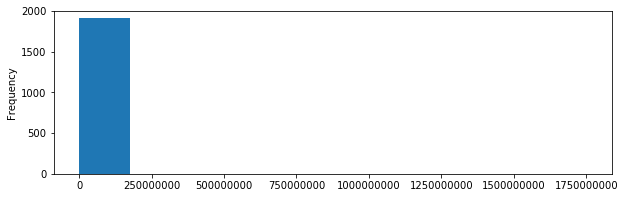

In [13]:
# plot distribution of Amount
plt.figure(figsize=(10,3))
df['amount'].plot.hist()
plt.ticklabel_format(useOffset=False, style='plain')
plt.show()

# clearly outliers

In [14]:
# remove outliers in amount using IQR

Q1 = df["amount"].quantile(0.25)
Q3 = df["amount"].quantile(0.75)
IQR = Q3 - Q1

mildThresholdLower = Q1 - (IQR * 1.5)
mildThresholdUpper = (IQR * 1.5) + Q3

# get index where Amount is > mildThresholdUpper
x = df.index[df["amount"] > mildThresholdUpper] 
df = df.drop(x)
x = df.index[df["amount"] < mildThresholdLower] 
df = df.drop(x)

# percent of data left
print("removed",round((1-len(df)/len(data_all))*100,1),"% or",(len(data_all)-len(df)),"rows from original data, which means we're left with", len(df), "rows of data")

removed 12.5 % or 241 rows from original data, which means we're left with 1683 rows of data


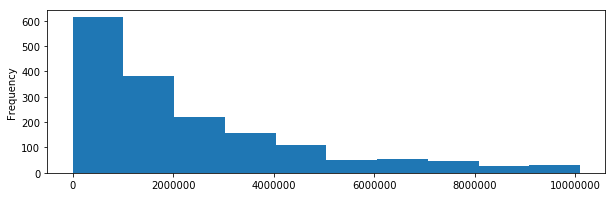

In [15]:
# plot distribution of Amount
plt.figure(figsize=(10,3))
df['amount'].plot.hist()
plt.ticklabel_format(useOffset=False, style='plain')
plt.show()

# much better

In [16]:
# Save to computer
os.chdir('/Users/Felicia/Documents/ComputationalLaw/')
# os.chdir('/Users/thymol/Desktop/Comp/pred-case-outcomes')

df.to_csv('combined_data.csv', index=False)

In [17]:
df.shape

(1683, 57)